# 变动r的粘性模型

## Index类

In [25]:
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

class IndexCoor(list):
    def __init__(self,ls):
        self.extend(ls)

    def __getitem__(self, item):   # 实现切片
        #cls = type(self)    # 相当于cls=Group()  但软编程可维护性好
        if isinstance(item, slice):
            start = item.start
            stop = item.stop
            L = IndexCoor([])
            for x in range(stop):
                if x>=start:
                    L.append(self[x])
            return L
        if isinstance(item,int):
            return list(self)[item]

    def nodeList(self):
        nodelist = {}
        for i in self:
            if i in nodelist:
                nodelist[i][7] +=1
            else:
                nodelist[i]={5:np.linalg.norm(np.array(i)-
                        np.array(self[0])),7:1}
        return nodelist

    def sideView(self):
        h = []
        nodelist = IndexCoor.nodeList(self)
        for k in nodelist:
            h.append(nodelist[k][7])
        a = Counter(h)
        return a 

    def caculateT(self,deltaR):#按照deltaR计算index积分
        nodelist = IndexCoor.nodeList(self)
        w = []
        delta = deltaR
        #delta = radius/2#qqq
        for key in nodelist:
            w.append([nodelist[key][5],nodelist[key][7]])
        w.sort()
        w = np.array(w)
        R = np.arange(0,np.max(w[:,0]),delta)
        RL = np.zeros((len(R),2)) 
        RL[:,0] = R
        for i in range(len(RL)):
            RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
            #RL delta*n 列是sum
        return RL
    
    def landCoor(self):# 根据人口index计算土地index
        nodelist = IndexCoor.nodeList(self)
        land = []
        for key,v in nodelist.items():
            land.append(key)
        landindex = IndexCoor(land)
        return landindex
#    def Rx(self,city):
#        Rrhox = caculate(self,city)
#        return Rrhox

    def spatial_range(self):
        nodelist = IndexCoor.nodeList(self)
        x = []
        y = []
        for k in nodelist.keys():
            x.append(k[0])
            y.append(k[1])
        return max(x),min(x),max(y),min(y)
      
    def paint(self,size = 0.1):
        nodelist = IndexCoor.nodeList(self)
        x = nodelist
        a = []
        c = []
        xmax,xmin,ymax,ymin = IndexCoor.spatial_range(self)
        for k,v in x.items():
            a.append(k)
            c.append(1/(v[7]))
        m = []
        n = []
        for i in a:
            m.append(i[0])
            n.append(i[1])
        plt.figure(figsize=(10,10),dpi=100)
        plt.scatter(m,n,size,c = c)
        plt.xlim((xmin,xmax))
        plt.ylim((ymin,ymax))
        plt.show()
        
    def fun(x, a, n):
        b = 1-x**(-a)
        return 1-np.sign(b)*np.abs(b)**n#numpy 不支持负值的指数
    
    def curveFit(self,deltaR):
        delta = deltaR
        x,y=[],[]
        for a in self.caculate(delta):
            x.append(a[0])
            y.append(a[1])
        popt,pcov = curve_fit(IndexCoor.fun,x,y)
        a = popt[0]
        n = popt[1]
        yvals = IndexCoor.fun(x,a,n)
        plt.plot(x, yvals, 'r',label='polyfit values')
        plt.legend()
        plt.plot(x,y,"b",label = "line")
        return [a,n]
    
    def caculate(self,deltaR):
        #根据nodelist计算s曲线
        nodelist = IndexCoor.nodeList(self)
        w = []
        delta = deltaR
    	#delta = radius/2#qqq
        for key in nodelist:
            w.append([nodelist[key][5],nodelist[key][7]])
        w.sort()
        w = np.array(w)
        R = np.arange(0,np.max(w[:,0]),delta)
        RL = np.zeros((len(R),2)) 
        RL[:,0] = R
        for i in range(len(RL)):
            RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
            #RL delta*n 列是sum
        Rrho = np.zeros((len(R),2))
        Rrho[:,0] = R + delta/2
        for i in range(len(Rrho)-1):
            Rrho[i,1] = (RL[i+1,1] - RL[i,1])/(math.pi*(delta**2+2*delta*RL[i,0]))
        a = Rrho
        xx = np.nonzero(a[:,1]==0) 
        if len(xx[0])==0:
            x = 0 
        else:
            x = xx[0][0]
        Rrhox = Rrho[:x,:x]
        return Rrhox
    
    def density(self):
        landindex = IndexCoor.landCoor(self)
        i = popindex.caculateT(5)[-1]/landindex.caculateT(5)[-1]
        return i[-1]

## main函数

In [42]:
from rtree import index
import numpy as np
import random

def initiate(radius,C,L):
    coordinate = np.ones(2)*L/2.0
    nodelist = {(coordinate[0],coordinate[1]):{5:0.0,7:1}} #5：到心距 7：点数
    index2coor = IndexCoor([(coordinate[0],coordinate[1])])
    #index2coor = [(coordinate[0],coordinate[1])]
    idx = index.Index()
    idx.insert(0,list(np.r_[coordinate,coordinate]))
    limitt = np.r_[coordinate - radius,coordinate + radius] 
    return index2coor,nodelist,idx,limitt

def choosenode(index2coor,nodelist,limitt,C):#?
    white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C
    #white = ( (list(limitt)[2]-list(limitt)[0])*(list(limitt)[3]-\
    #list(limitt)[1])-len(nodelist) )*C
    exist = len(index2coor)+len(nodelist)*C
    rnd = random.random()*( exist + white )
    if rnd>exist:
        while 1:
            ii = int( random.random()*(limitt[2]-limitt[0]) + limitt[0] )
            jj = int( random.random()*(limitt[3]-limitt[1]) + limitt[1] )
            if (ii,jj) not in nodelist:
                return (ii,jj),0 # 这个结构如果产生不了输出就会死循环，
            #先随机再判断，贝叶斯问题？？
            #用蒙特卡罗验证落到各个空格子概率相等？
    else:
        pos = random.randint(0,len(index2coor)-1)#左闭右闭
        #随机落到落点顺序上  这很重要
        return index2coor[pos],1

def onestep(index2coor,nodelist,idx,limitt,radius,C,h,L,maxR):
    two,flag = choosenode(index2coor,nodelist,limitt,C)  
    i,j = two[0],two[1]
    d= np.linalg.norm(np.array([i,j])-L/2)
    maxR = max(maxR,d)
    #radiuss = radius + int(maxR/2)
    #radiuss = radius + int(maxR/10)
    #radiuss = radius + int( np.log10(maxR+1)  )## 改动
    radiuss = radius + int(10000/(1+np.exp(-maxR+10)))
    if flag == 0:
        intersection = list(idx.intersection([i-radiuss,j-radiuss,i+radiuss,j+radiuss])) 
        if len(intersection) > 0:
            for key in intersection:
                if np.linalg.norm(np.array(index2coor[key])-np.array((i,j))) <= radiuss:
                    state = 1
                    break
                else:
                    state = 0
            if state == 1:
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radiuss)
        return index2coor,nodelist,idx,limitt,maxR,radiuss#

    elif flag==1: 
        if getDeltaMax(i,j,nodelist) <= h:
            nodelist[(i,j)][7] += 1
            index2coor.append((i,j))
        else:
            while ((i,j) in nodelist.keys()) and (getDeltaMax(i,j,nodelist) > h ):
            #while getDeltaMax(i,j,nodelist) > h :
                (i,j) = sandpile(i,j,h,nodelist)
            if (i,j) in nodelist.keys():#溢出到有点的格子
                nodelist[(i,j)][7] += 1
                #index2coor[len(index2coor)]=(i,j)
                index2coor.append((i,j))
            else:#溢出到空格子
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radius)
        return index2coor,nodelist,idx,limitt,maxR,radiuss#

def insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radiuss):
    nodelist[(i,j)] = {5:np.linalg.norm(np.array([i,j])-L/2),7:1}
    #index2coor[len(index2coor)+1]=(i,j)
    index2coor.append((i,j))
    newpoint = [i,j]
    #这里前往小心，index2coor已经新增了点，所以要减1
    idx.insert( len(index2coor)-1, np.r_[newpoint, newpoint] )  ###idx
    for x in range(2):
        limitt[x]   = round(min(limitt[x],newpoint[x]-radiuss))
        limitt[x+2] = round(max(limitt[x+2],newpoint[x]+radiuss))
    return index2coor,nodelist,idx,limitt

def sandpile(i,j,h,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    #邻接阵arov
    arov={}
    fit=[]#满足溢出的位置
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        if delta == h+1:
            fit.append(m)
    n = len(fit)
    if n == 1:
        pos = fit[0]
    else:
        pos = fit[random.randint(0,n-1)]
    return arounddic[pos]   

def getDeltaMax(i,j,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    arov={}
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        deltas.append(delta)
    return max(deltas)

## city类

In [43]:
class city(object):
    def __init__(self,H,C,maxP,radius=10,L=10**5):
        # H 沙堆阈值 C 引力 maxP 最大人口 radius 引力范围 L 背景范围 
        # deltaP 间隔人口 delta 密度采样间隔
        self.C,self.H,self.maxP = C,H,maxP
        self.radius,self.L = radius,L

    def step(self):
        #index2coor,nodelist,idx,limitt = main.initiate(self.radius,self.C,self.L)#初始化
        index2coor,nodelist,idx,limitt = initiate(self.radius,self.C,self.L)
        maxR = 0
        while len(index2coor) < self.maxP:
            index2coor,nodelist,idx,limitt,maxR,radiuss = onestep\
            (index2coor,nodelist,idx,limitt,self.radius,self.C,self.H,self.L,maxR)
            print(maxR)
        return index2coor    

# 测试

In [44]:
5 + int(10000/(1+np.exp(-40+10)))

10004

In [45]:
demo = city(4,0.05,50000,radius=5)

In [46]:
popindex = demo.step()

5.385164807134504
121.63058825805291
9380.28496368847
9380.28496368847
13653.161575254282
24065.327693592706
24065.327693592706
24065.327693592706
24065.327693592706
24065.327693592706
24065.327693592706
25035.53500526801
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
33428.8844264956
36363.437488774354
36363.437488774354
36363.437488774354
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
37598.250198646216
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.58384003385
50976.5

limit_output extension: Maximum message size of 10000 exceeded with 11006 characters

In [47]:
popindex.paint()

KeyboardInterrupt: 

In [58]:
popindex.sideView()

Counter({1: 4435, 2: 129, 3: 30, 4: 18, 5: 22, 6: 1, 7: 3, 8: 1})

In [60]:
popindex.caculate(5)

array([[2.50000000e+00, 1.56608464e+00],
       [7.50000000e+00, 5.55981268e-01],
       [1.25000000e+01, 1.57881704e-01],
       [1.75000000e+01, 1.38237436e-01],
       [2.25000000e+01, 5.94178454e-02],
       [2.75000000e+01, 4.97720913e-02],
       [3.25000000e+01, 3.62383563e-02],
       [3.75000000e+01, 4.15924918e-02],
       [4.25000000e+01, 3.59502930e-02],
       [4.75000000e+01, 1.74232780e-02],
       [5.25000000e+01, 2.48584863e-02],
       [5.75000000e+01, 1.43931427e-02],
       [6.25000000e+01, 1.12045080e-02],
       [6.75000000e+01, 1.32039656e-02],
       [7.25000000e+01, 9.22001050e-03],
       [7.75000000e+01, 1.15002281e-02],
       [8.25000000e+01, 1.11890748e-02],
       [8.75000000e+01, 1.12772645e-02],
       [9.25000000e+01, 7.91473231e-03],
       [9.75000000e+01, 6.85590524e-03],
       [1.02500000e+02, 4.34764723e-03],
       [1.07500000e+02, 7.40255549e-03],
       [1.12500000e+02, 7.07355303e-03],
       [1.17500000e+02, 7.04345280e-03],
       [1.225000

limit_output extension: Maximum message size of 10000 exceeded with 10783 characters

E:\Miniconda\envs\py35\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in power


[-0.020963273914552563, 5.96887927757128]

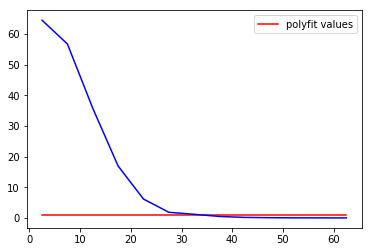

In [16]:
popindex.curveFit(5)

In [17]:
landindex = popindex.landCoor()
landindex

[(50005, 49998),
 (50009, 50000),
 (50000, 50028),
 (49994, 49985),
 (49998, 50034),
 (49966, 50011),
 (50005, 49983),
 (50011, 49982),
 (50022, 49993),
 (50026, 49995),
 (49990, 50013),
 (50007, 50001),
 (50016, 49991),
 (49996, 50008),
 (50002, 50022),
 (49987, 50000),
 (49992, 49990),
 (50009, 49960),
 (49977, 50012),
 (50017, 49986),
 (49999, 50006),
 (49980, 50001),
 (50006, 49964),
 (50005.0, 50007.0),
 (50009, 50009),
 (50033, 49986),
 (50039, 49996),
 (49998, 50037),
 (49977, 49959),
 (50005, 49976),
 (49972, 50000),
 (50011, 49975),
 (50022, 49984),
 (49970, 50010),
 (49990, 50004),
 (50007, 50030),
 (49989, 49967),
 (50015, 50004),
 (50016, 50014),
 (49996, 50007),
 (50002, 50017),
 (50041, 49994),
 (49987, 50009),
 (49992, 49997),
 (50009, 49969),
 (49995, 49983),
 (50017, 50011),
 (49999, 50015),
 (49963, 50006),
 (50008, 49997),
 (49988, 50006),
 (50005, 50000),
 (49973, 49996),
 (50023, 49996),
 (49990, 49980),
 (50012, 49999),
 (49970, 50005),
 (49990, 49999),
 (49989, 4

limit_output extension: Maximum message size of 10000 exceeded with 17245 characters

[3.746186037545486, 138045.87057648535]

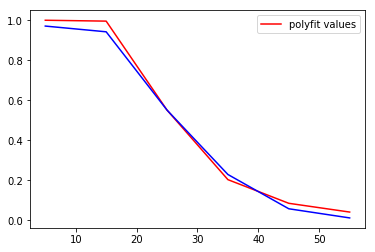

In [18]:
landindex.curveFit(10)

In [20]:
def density(popindex):
    landindex = popindex.landCoor()
    i = popindex.caculateT(5)[-1]/landindex.caculateT(5)[-1]
    return i[-1]

In [21]:
density(popindex)

18.04693140794224

In [24]:
density(popindex[0:25000])

12.157587548638132

In [ ]:
x = [x for x in range(-100,100)]
